In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import  pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Attention, Reshape, Multiply
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from dataclasses import dataclass, asdict
import yaml
from typing import Optional, Union, List
from dacite import from_dict
import numpy as np
import math
import json
import itertools
import ast
import cv2
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
@dataclass
class Resize:
    resizeW: int
    resizeH: int

@dataclass
class DullRazor:
    enabled: bool
    razorblur: str
    mediankernel_razorblur: int
    filterstructure:int
    lowerbound:int
    inpaintmat:int

@dataclass
class Blur:
    enabled: bool
    normalblur: str
    mediankernel_blur: int
    blurnum: int

@dataclass
class Softattention:
    alpha: float
    beta: float
    gamma: float
    
@dataclass
class AttentionConfig:
    resize: Resize
    dull_razor: DullRazor
    blur: Blur
    soft_attention: Softattention
        
@dataclass
class LossParams:
    func: str
    params: Optional[str]

@dataclass
class OptimizerParams:
    func: str
    params: Optional[str]

@dataclass
class InputDataParams:
    input_size: str

@dataclass
class ModelParams:
    batch_size: int
    arch: str
    freeze_pretrained: bool
    steps_per_epoch: int
    metrics: List[str]
    pretrained_weight: Optional[str]
    loss: Optional[LossParams]
    optimizer: Optional[OptimizerParams]
    class_weight_mu: float

@dataclass
class ModelsConfig:
    model_name: str
    input_params: InputDataParams
    model_params: ModelParams
    attention_config: Optional[AttentionConfig]

In [14]:
yaml_config = """
vgg16:
  model_name: "vgg16-1"
  input_params:
    input_size: (224,224)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.DenseNet121
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-3}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
"""

In [6]:
#Optional Preprocessing
class Ham10000Attention:
    
    def __init__(self, model, attention_config):
        self.config = attention_config
        
        self.input_shape = (self.config.resize.resizeW, self.config.resize.resizeH)
        self.model = model
        #self.attention_output = self.heatmap(self.image, model)
    
    def resize(self, img):
        return cv2.resize(img, self.input_shape, interpolation=cv2.INTER_LINEAR)    
            
    def dull_razor(self, img):
        cfg = self.config.dull_razor
        if cfg.razorblur == "M":
            img = cv2.medianBlur(img,cfg.mediankernel_razorblur)
        elif cfg.razorblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_razorblur, cfg.mediankernel_razorblur),0)

        #gyimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #filtersize = (cfg.filterstructure,cfg.filterstructure)
        #kernelrazor = cv2.getStructuringElement(cv2.MORPH_RECT, filtersize)
        #gyimage = cv2.morphologyEx(gyimage, cv2.MORPH_BLACKHAT, kernelrazor)
#
        #retrazor, maskrazor = cv2.threshold(gyimage, cfg.lowerbound, 255, cv2.THRESH_BINARY)
        #img = cv2.inpaint(img, maskrazor, cfg.inpaintmat, cv2.INPAINT_TELEA)
        return img

    def blur(self, img):
        cfg = self.config.blur
        if cfg.normalblur == "M":
            img = cv2.medianBlur(img, cfg.mediankernel_blur)
        elif cfg.normalblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_blur, cfg.mediankernel_blur), 0)
        return img

    def softention_preprocess(self, img):
        first = preprocess_input(img)
        expanded_image = np.expand_dims(first, 0)
        return expanded_image

    def softention_mapping(self, img, LayerNumber, input_shape, SoftentionImage):
        cfg = self.config.soft_attention
        activated = self.model.predict(img)
        output = np.abs(activated)
        output = np.sum(output, axis = -1).squeeze() 
        output = cv2.resize(output, input_shape)
        output /= output.max() 
        #output *= 255 
        #Weights =  255 - output.astype('uint8')
#
        #heatmap = cv2.applyColorMap(Weights, cv2.COLORMAP_JET)
        #heatmap = cv2.addWeighted(heatmap, cfg.alpha, SoftentionImage, cfg.beta, cfg.gamma)
        return output
    
    def heatmap(self, img):
        #resized_image = self.resize(img)
        hair_removed_image = self.dull_razor(img)
        softentionImage = self.blur(hair_removed_image)
        expanded_image = self.softention_preprocess(softentionImage)
        heatmap = self.softention_mapping(expanded_image, -1, self.input_shape, softentionImage)
        return heatmap
    
    def preprocess(self, img):
        
        img = self.resize(img)
        heatmap = self.heatmap(img)
        mask = heatmap.reshape(self.config.resize.resizeW,self.config.resize.resizeH,1)
        out = Multiply()([tf.cast(img, tf.float32),mask])
        img = tf.keras.utils.normalize(out)
        return img

In [29]:
class ModelTrainer():

  def __init__(self, train_dir, test_dir, model_name, model_dir, batch_size = 16, 
               target_size = (224,224), model_params = None, class_weight_mu = 0.4, attention_config = None,retrain = False):
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.batch_size = batch_size
    self.target_size = target_size
    self.model_name = model_name
    self.model_dir = model_dir
    self.checkpoint_path = f"{self.model_dir}/{self.model_name}"
    if attention_config:
        print("attention model")
        self.attention_model = self.attention(attention_config)
    else:
        self.attention_model = None
    self.train_generator, self.validation_generator, self.attention_generator = self.get_generators()
    self.set_class_weight(class_weight_mu)
    self.model_params = model_params
    if retrain == True or not(self.load_trained_model()):
      if model_params:
        self.register_model(self.model_architecture(model_params))

  @staticmethod
  def load_from_config(config, base_dir = '/home/ubuntu/data/3classes/', retrain = False):
    train_dir = f"{base_dir}/HAM10000_train_by_class/"
    test_dir = f"{base_dir}/HAM10000_test_by_class/"
    model_dir = f"{base_dir}/models"
    cfg = from_dict(data_class=ModelsConfig, data=config)
    model_trainer = ModelTrainer(train_dir, test_dir, cfg.model_name, model_dir, batch_size = cfg.model_params.batch_size or 16,
                                 target_size = eval(cfg.input_params.input_size),class_weight_mu = cfg.model_params.class_weight_mu,
                                 model_params = cfg.model_params, attention_config = cfg.attention_config, retrain = retrain)    
    return model_trainer

  @classmethod
  def img_normalize(cls,img):
    #img = cv2.imread(img)
    mean = [0.5456423, 0.5700427, 0.7630366]
    sd = [0.15261365, 0.16997027, 0.14092803]
    img = cv2.resize(img, (224,224))
    img = img.astype('float32')/255.
    img = (img - mean) / sd
    #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    return img     
  
  def attention(self, attention_config):
    attention_pretrained_model = ResNet50(input_shape=(224,224, 3),
                                                include_top=False,
                                                weights='imagenet')
    out_layer = attention_pretrained_model.layers[-1]
    model = tf.keras.models.Model(inputs = attention_pretrained_model.inputs, outputs = out_layer.output)
    return Ham10000Attention(model,attention_config)
  
  def register_model(self, model):
    self.model = model
    self.model.compile(loss=self.model_params.loss.func, optimizer=self.optimizer(), metrics=self.model_params.metrics)
    if not os.path.exists(self.checkpoint_path):
      os.makedirs(self.checkpoint_path)
    self.model.save(f"{self.checkpoint_path}/model.h5")

  def optimizer(self):
    optimizer_func = eval(self.model_params.optimizer.func)
    optimizer_params = ast.literal_eval(self.model_params.optimizer.params)
    optimizer = optimizer_func(**optimizer_params)
    return optimizer

  def summary(self):
    self.model.summary()

  def show_samples(self, rows = 4, columns = 4):
    x, y = next(self.train_generator)
    fig = plt.figure(figsize=(8, 8))
    for i in range(0, columns*rows):
      img = x[i].astype(int)
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(img)
    plt.show()
  
  def get_generators(self):
    train_datagen = ImageDataGenerator(
                                  featurewise_center=True, 
                                  featurewise_std_normalization=True
                                  #rotation_range = 20,
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #horizontal_flip = True,
                                  #vertical_flip = True,
                                  #preprocessing_function = ModelTrainer.img_normalize)
                                  #preprocessing_function = self.attention_model.preprocess
                                  #self.attention_model.preprocess)
                                  #fill_mode = 'nearest'
                                    )
    test_datagen = ImageDataGenerator(
                                     featurewise_center=True, 
                                    featurewise_std_normalization=True
                                    #preprocessing_function = self.attention_model.preprocess
                                     )
    if self.attention_model:
        attention_generator = ImageDataGenerator(preprocessing_function = self.attention_model.heatmap)
    else:
        attention_generator = None
    
    train_generator = train_datagen.flow_from_directory(directory=self.train_dir, class_mode='sparse',shuffle=True,
                                                  batch_size=self.batch_size,target_size=self.target_size)
    validation_generator = test_datagen.flow_from_directory(directory=self.test_dir, class_mode='sparse',shuffle=False,
                                                       batch_size=self.batch_size,target_size=self.target_size)
    return train_generator, validation_generator, attention_generator
  
  def create_class_weight(self, labels_dict, mu):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
      score = math.log(mu*total/float(labels_dict[key]))
      score = mu*total/float(labels_dict[key])
      class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

  def set_class_weight(self, mu):  
    class_dict = dict()
    for dir in os.listdir(self.train_dir):
      class_dict[dir] = len(os.listdir(f"{self.train_dir}/{dir}"))

    weights = self.create_class_weight(class_dict, mu)
    self.class_weight = {}
    class_indices = self.train_generator.class_indices
    for cls in weights:
      self.class_weight[class_indices[cls]] = weights[cls]
  
  def _callback(self):
    filepath = self.checkpoint_path + '/weights.h5'
    checkpoint_dir = os.path.dirname(self.checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    save_weights_only=True,
                                                    verbose=2,
                                                    save_best_only=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    return [cp_callback,learning_rate_reduction]
  
  def model_architecture(self, model_params, CLASS_N = 3):
    
    arch = eval(model_params.arch)
    input_shape =  (self.target_size[0],self.target_size[1],3)
    pretrained = arch(input_shape = input_shape, include_top=False, weights=model_params.pretrained_weight or None)

    for layer in pretrained.layers:
      layer.trainable = not(model_params.freeze_pretrained)
    
    x = Flatten()(pretrained.layers[-1].output)
    #x = Dense(5000, kernel_regularizer=regularizers.l1_l2(0.00001), activity_regularizer=regularizers.l2(0.00001), activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(x) 
    #x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(CLASS_N, activation = 'softmax')(x)
    
    model = Model(inputs = pretrained.input, outputs = x)
    print("New model created")
    return model
  
  def load_trained_model(self):
    if os.path.exists(self.checkpoint_path):
      print("Trained model exists and it will be loaded")
      self.model = load_model(f'{self.checkpoint_path}/model.h5')
      self.model.load_weights(f'{self.checkpoint_path}/weights.h5')
      return True
    return False
  
  def train(self, epochs=10, verbose=2):
    with tf.device('/device:GPU:0'):
      model_info = self.model.fit(
                      x=self.train_generator, 
                      steps_per_epoch=self.train_generator.samples // self.batch_size+1,  
                      epochs=epochs, 
                      validation_steps=self.validation_generator.samples // self.batch_size+1,
                      validation_data=self.validation_generator, 
                      verbose=verbose,
                      callbacks=self._callback(),
                      class_weight=self.class_weight
                  )
      self.model_info = model_info
      with open(f'{self.model_dir}/history.json','w') as fp:
        json.dump(str(self.model_info.history), fp)
    
  def confusion_matrix(self):    
    Y_pred = self.model.predict(self.validation_generator, self.validation_generator.samples // self.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(self.validation_generator.classes, y_pred)
    target_names = list(self.validation_generator.class_indices.keys())
    cls_rpt = classification_report(self.validation_generator.classes, y_pred, target_names=target_names)
    #self.plot_confusion_matrix(cm, target_names)

  def plot_confusion_matrix(self):
    
    normalize=False
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    Y_pred = self.model.predict(self.validation_generator, self.validation_generator.samples // self.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(self.validation_generator.classes, y_pred)
    classes = list(self.validation_generator.class_indices.keys())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  
    print(set(y_pred))
    
    cls_rpt = classification_report(self.validation_generator.classes, y_pred, target_names=classes)
    print(cls_rpt)

  def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('modelhttp://127.0.0.1:8888/notebooks/notebooks/kiru/framework.ipynb# '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['training', 'validation'])

  def show_plot():
    plt.subplots(figsize=(10,10))
    plt.tight_layout()
    display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [49]:
name = 'vgg16'
model_config = yaml.safe_load(yaml_config)
model_trainer = ModelTrainer.load_from_config(model_config[name],'/home/ubuntu/data/3classes/', retrain = True)
model_trainer.class_weight = {0:2.5,1:4,2:1.0}

attention model
Found 25500 images belonging to 3 classes.
Found 1992 images belonging to 3 classes.
New model created


In [52]:
model_trainer.validation_generator.class_indices

{'bcc': 0, 'mel': 1, 'others': 2}

In [54]:
%matplotlib inline

797/797 [==============================] - 175s 220ms/step - loss: 4.0060 - accuracy: 0.7307 - val_loss: 2.9592 - val_accuracy: 0.6295

Epoch 00001: val_loss improved from inf to 2.95919, saving model to /home/ubuntu/data/3classes//models/vgg16-1/weights.h5
{0, 1, 2}
              precision    recall  f1-score   support

         bcc       0.22      0.91      0.35        99
         mel       0.28      0.62      0.38       219
      others       0.94      0.61      0.74      1674

    accuracy                           0.63      1992
   macro avg       0.48      0.71      0.49      1992
weighted avg       0.83      0.63      0.68      1992

797/797 [==============================] - 176s 220ms/step - loss: 3.0593 - accuracy: 0.7591 - val_loss: 2.2053 - val_accuracy: 0.6737

Epoch 00001: val_loss improved from inf to 2.20533, saving model to /home/ubuntu/data/3classes//models/vgg16-1/weights.h5
{0, 1, 2}
              precision    recall  f1-score   support

         bcc       0.25     

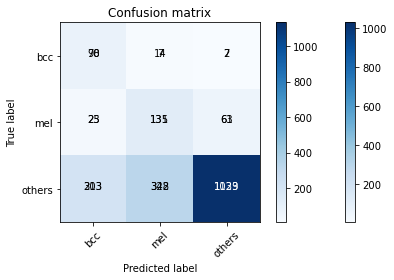

In [53]:
for i in range(2):
    model_trainer.train(epochs=1,verbose=1)
    model_trainer.plot_confusion_matrix()